In [1]:
import random
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
import torch.nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.notebook import tqdm
from torchvision import datasets, models, transforms
import IPython.display as ipd

In [2]:
# make dataset [filename, label, sample rate, num channels] for train data
# and [filename, sample rate, num channels] for test data

def create_audio_info_dataset(train: bool, label=''):
    dir = f'Training_Data/{label}/' if train else f'Testing_Data/'
    data = []
    if train:
        for filename in Path(dir).iterdir():
            metadata = torchaudio.info(filename)
            data.append([str(filename), label, metadata.sample_rate, metadata.num_channels])
    else:
        for filename in Path(dir).iterdir():
            metadata = torchaudio.info(filename)
            data.append([str(filename), metadata.sample_rate, metadata.num_channels])
    return data

In [3]:
# get general information about audiofiles

human_info = create_audio_info_dataset(label='human', train=True)
spoof_info = create_audio_info_dataset(label='spoof', train=True)

test_info = create_audio_info_dataset(train=False)

df_human = pd.DataFrame(np.array(human_info),
                        columns=['filename', 'label', 'sample_rate', 'num_channels'])
df_spoof = pd.DataFrame(np.array(spoof_info),
                        columns=['filename', 'label', 'sample_rate', 'num_channels'])

df_test = pd.DataFrame(np.array(test_info),
                       columns=['filename', 'sample_rate', 'num_channels'])

print(f'Train data: \n\t '
      f'human: \n\t\t '
      f'amount: {len(human_info)} \n\t\t '
      f'sample rate unique: {df_human.sample_rate.unique()} \n\t\t '
      f'num channels unique: {df_human.num_channels.unique()} \n\t '

      f'spoof: \n\t\t '
      f'amount: {len(spoof_info)} \n\t\t '
      f'sample rate unique: {df_spoof.sample_rate.unique()} \n\t\t '
      f'num channels unique: {df_spoof.num_channels.unique()} \n '
      
      f'Test data: \n\t\t '
      f'amount: {len(test_info)} \n\t\t '
      f'sample rate unique: {df_test.sample_rate.unique()} \n\t\t '
      f'num channels unique: {df_test.num_channels.unique()} \n\t ')


Train data: 
	 human: 
		 amount: 10322 
		 sample rate unique: ['16000'] 
		 num channels unique: ['1'] 
	 spoof: 
		 amount: 39678 
		 sample rate unique: ['16000'] 
		 num channels unique: ['1'] 
 Test data: 
		 amount: 5000 
		 sample rate unique: ['16000'] 
		 num channels unique: ['1'] 
	 


In [4]:
# making dataset [filename, label] for train data
# and [filename] for test data

def create_filename_dataset(train: bool, label=''):
    dir = f'Training_Data/{label}/' if train else f'Testing_Data/'
    data = []
    if train:
        for filename in Path(dir).iterdir():
            data.append([str(filename), label])
    else:
        for filename in Path(dir).iterdir():
            data.append(str(filename))
    return data

In [5]:
# make datasets and dataloaders

human_filenames = create_filename_dataset(label='human', train=True)
spoof_filenames = create_filename_dataset(label='spoof', train=True)

test_filenames = create_filename_dataset(train=False)

human_filenames_loader = DataLoader(human_filenames, batch_size=1)
spoof_filenames_loader = DataLoader(spoof_filenames, batch_size=1)

test_filenames_loader = DataLoader(test_filenames, batch_size=1)

In [6]:
# load audio example
waveform, sample_rate = torchaudio.load(human_filenames[150][0])
sample_rate, waveform

(16000, tensor([[ 0.0003,  0.0003,  0.0002,  ...,  0.0228,  0.0074, -0.0074]]))

Waveform size: torch.Size([1, 48000])
Sample rate of waveform: 16000


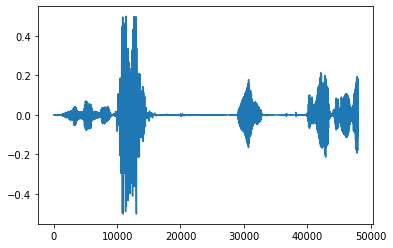

In [7]:
def plot_audio(waveform, sample_rate):
    print('Waveform size:', waveform.size())
    print('Sample rate of waveform:', sample_rate)
    plt.plot(waveform.squeeze().numpy())

# plot and play audio example
plot_audio(waveform, sample_rate)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Spectogram size: torch.Size([128, 100])


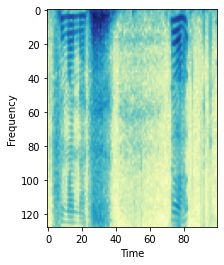

In [8]:
def show_spectrogram(waveform):
    waveform = torchaudio.transforms.Resample(orig_freq=1600, new_freq=800)(waveform)
    spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=800)(waveform)\
        .squeeze()
    spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    max_length = 100
    if spectrogram.shape[1] < max_length:
            spectrogram = F.pad(spectrogram, (0, max_length - spectrogram.shape[1]))
    else:
            spectrogram = spectrogram[:, :max_length]

    print('Spectogram size:', spectrogram.size())
    
    plt.figure()
    plt.imshow(spectrogram.numpy(), cmap='YlGnBu')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# create spectrogram of audio example
show_spectrogram(waveform)

In [9]:
class SpectrogramDataset(Dataset):
    def __init__(self, filename_loaders, train_mode:bool):
        self.filename_loaders = filename_loaders
        self.train_mode = train_mode

        dataset = []
        for loader in self.filename_loaders:
          for data, _ in zip(loader, tqdm(range(len(loader.dataset)))):
              if self.train_mode:
                  filename, label = data
                  # label: 0 for spoof, 1 for human
                  label = 0 if label[0] == 'spoof' else 1
                  spectrogram = self.get_spectrogram(filename[0])
                  dataset.append([spectrogram, label])
              else:
                  filename = data[0]
                  spectrogram = self.get_spectrogram(filename)
                  dataset.append([spectrogram, filename[filename.find('/') + 1:]])

        if self.train_mode:
            random.shuffle(dataset)

        # data is [spectrogram, label] for train mode
        # data is [spectrogram, filename] for test mode
        self.data = dataset

    @staticmethod
    def get_spectrogram(filename):
        waveform, _ = torchaudio.load(filename)
        waveform = torchaudio.transforms.Resample(orig_freq=1600, new_freq=800)(waveform)

        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=800)(waveform)\
                        .squeeze()
        spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)

        # resize spectrogram
        max_length = 100
        if spectrogram.shape[1] < max_length:
            spectrogram = F.pad(spectrogram, (0, max_length - spectrogram.shape[1]))
        else:
            spectrogram = spectrogram[:, :max_length]
        return spectrogram

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.train_mode:
            spectrogram, label  = self.data[idx]
            return spectrogram, label
        else:
            return self.data[idx]

In [10]:
train_spectrogram_dataset = SpectrogramDataset([human_filenames_loader, spoof_filenames_loader], train_mode=True)
test_spectrogram_dataset = SpectrogramDataset([test_filenames_loader], train_mode=False)

  0%|          | 0/10322 [00:00<?, ?it/s]

  0%|          | 0/39678 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [28]:
train_data_len = len(train_spectrogram_dataset) * 9 / 10
test_data_len = len(train_spectrogram_dataset) * 1 / 10
train_data_len, test_data_len

(45000.0, 5000.0)

In [29]:
# split data to test and train
train_data, test_data = torch.utils.data.random_split(train_spectrogram_dataset,
                                                      [int(train_data_len), int(test_data_len)])

In [30]:
train_dataloader = DataLoader(train_data, batch_size=200)
test_dataloader = DataLoader(test_data, batch_size=200)

In [31]:
train_dataloader.dataset[0][0].size()

torch.Size([128, 100])

In [32]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.pool = nn.MaxPool2d(kernel_size=4)
        self.lin1 = nn.Linear(20 * 6 * 5, 300)
        self.lin2 = nn.Linear(300, 100)
        self.lin3 = nn.Linear(100, 50)
        self.lin4 = nn.Linear(50, 20)
        self.lin5 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        # x.size: [10, 1, 128, 100]
        x = F.relu(self.bn1(self.conv1(x)))
        # x.size: [10, 10, 124, 96]
        x = self.pool(x)
        # x.size: [10, 10, 31, 24]
        x = F.relu(self.bn2(self.conv2(x)))
        # x.size: [10, 20, 27, 20]
        x = self.pool(x)
        # x.size: [10, 20, 6, 5]

        x = x.view(-1, 20 * 6 * 5)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = torch.sigmoid(self.lin5(x))
        return x

In [33]:
net = ConvNet()
net

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=600, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=20, bias=True)
  (lin5): Linear(in_features=20, out_features=1, bias=True)
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

[1,     1] loss: 0.007
[1,   101] loss: 0.410
[1,   201] loss: 0.242


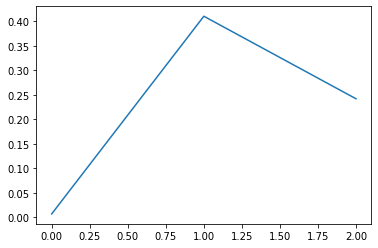

  0%|          | 0/225 [00:00<?, ?it/s]

[2,     1] loss: 0.048
[2,   101] loss: 0.173
[2,   201] loss: 0.153


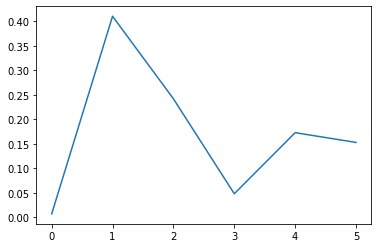

  0%|          | 0/225 [00:00<?, ?it/s]

[3,     1] loss: 0.033
[3,   101] loss: 0.123
[3,   201] loss: 0.118


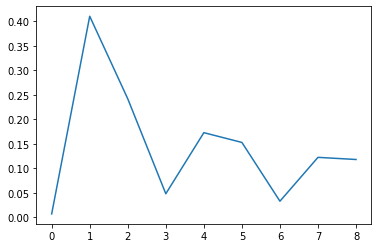

  0%|          | 0/225 [00:00<?, ?it/s]

[4,     1] loss: 0.027
[4,   101] loss: 0.099
[4,   201] loss: 0.102


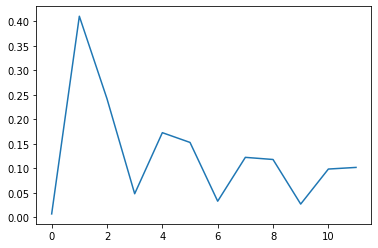

  0%|          | 0/225 [00:00<?, ?it/s]

[5,     1] loss: 0.022
[5,   101] loss: 0.089
[5,   201] loss: 0.094


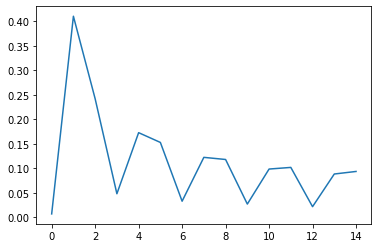

  0%|          | 0/225 [00:00<?, ?it/s]

[6,     1] loss: 0.020
[6,   101] loss: 0.083
[6,   201] loss: 0.079


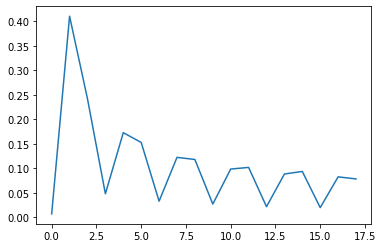

  0%|          | 0/225 [00:00<?, ?it/s]

[7,     1] loss: 0.017
[7,   101] loss: 0.070
[7,   201] loss: 0.077


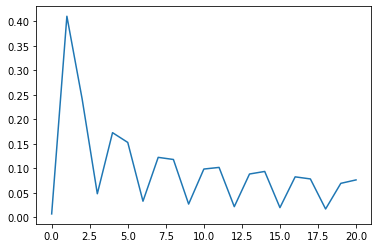

  0%|          | 0/225 [00:00<?, ?it/s]

[8,     1] loss: 0.016
[8,   101] loss: 0.064
[8,   201] loss: 0.071


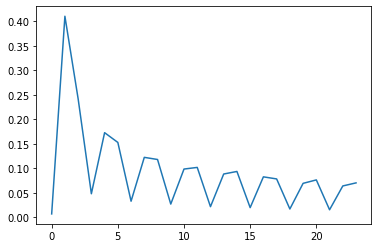

  0%|          | 0/225 [00:00<?, ?it/s]

[9,     1] loss: 0.015
[9,   101] loss: 0.058
[9,   201] loss: 0.063


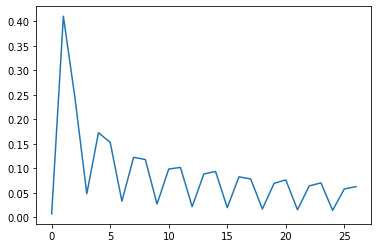

  0%|          | 0/225 [00:00<?, ?it/s]

[10,     1] loss: 0.013
[10,   101] loss: 0.050
[10,   201] loss: 0.060


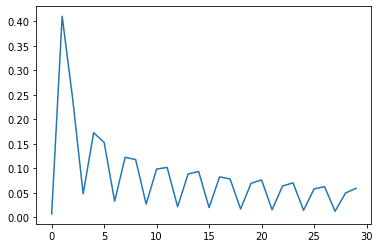

  0%|          | 0/225 [00:00<?, ?it/s]

[11,     1] loss: 0.010
[11,   101] loss: 0.049
[11,   201] loss: 0.054


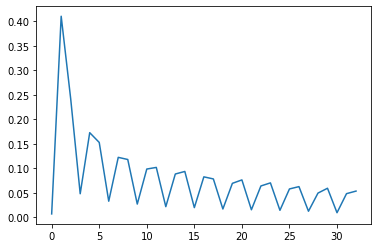

  0%|          | 0/225 [00:00<?, ?it/s]

[12,     1] loss: 0.011
[12,   101] loss: 0.049
[12,   201] loss: 0.053


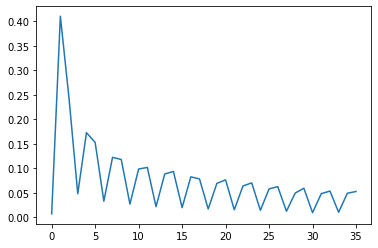

  0%|          | 0/225 [00:00<?, ?it/s]

[13,     1] loss: 0.011
[13,   101] loss: 0.042
[13,   201] loss: 0.048


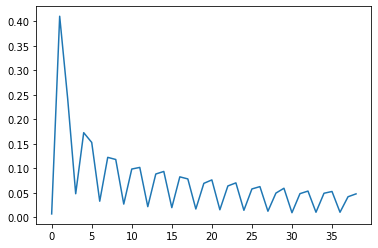

  0%|          | 0/225 [00:00<?, ?it/s]

[14,     1] loss: 0.008
[14,   101] loss: 0.037
[14,   201] loss: 0.042


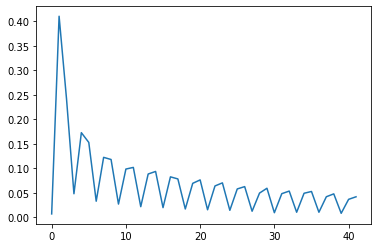

  0%|          | 0/225 [00:00<?, ?it/s]

[15,     1] loss: 0.010
[15,   101] loss: 0.043
[15,   201] loss: 0.038


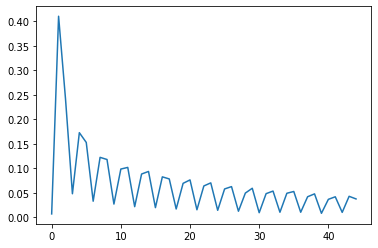

  0%|          | 0/225 [00:00<?, ?it/s]

[16,     1] loss: 0.007
[16,   101] loss: 0.036
[16,   201] loss: 0.034


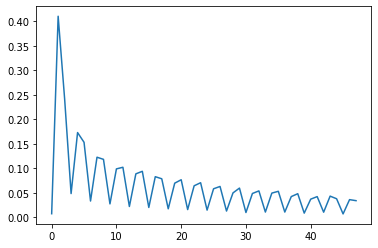

  0%|          | 0/225 [00:00<?, ?it/s]

[17,     1] loss: 0.006
[17,   101] loss: 0.036
[17,   201] loss: 0.029


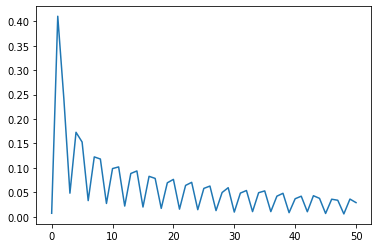

  0%|          | 0/225 [00:00<?, ?it/s]

[18,     1] loss: 0.005
[18,   101] loss: 0.032
[18,   201] loss: 0.033


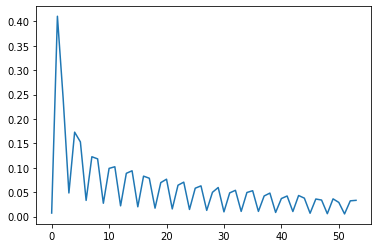

  0%|          | 0/225 [00:00<?, ?it/s]

[19,     1] loss: 0.006
[19,   101] loss: 0.030
[19,   201] loss: 0.034


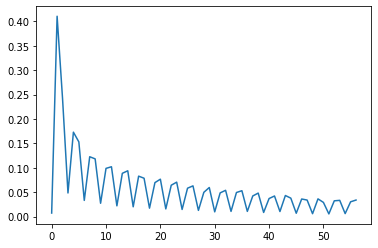

  0%|          | 0/225 [00:00<?, ?it/s]

[20,     1] loss: 0.006
[20,   101] loss: 0.029
[20,   201] loss: 0.029


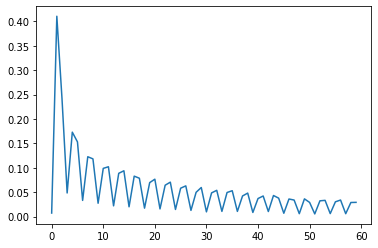

  0%|          | 0/225 [00:00<?, ?it/s]

[21,     1] loss: 0.007
[21,   101] loss: 0.024
[21,   201] loss: 0.027


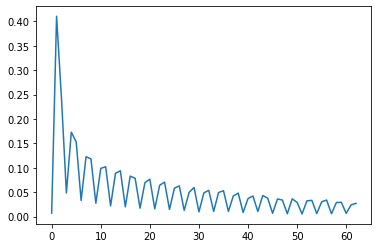

  0%|          | 0/225 [00:00<?, ?it/s]

[22,     1] loss: 0.006
[22,   101] loss: 0.023
[22,   201] loss: 0.024


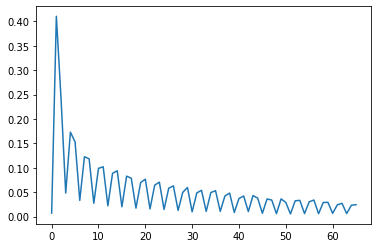

  0%|          | 0/225 [00:00<?, ?it/s]

[23,     1] loss: 0.005
[23,   101] loss: 0.024
[23,   201] loss: 0.021


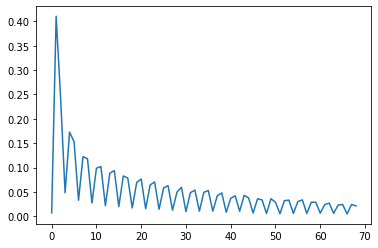

  0%|          | 0/225 [00:00<?, ?it/s]

[24,     1] loss: 0.004
[24,   101] loss: 0.021
[24,   201] loss: 0.021


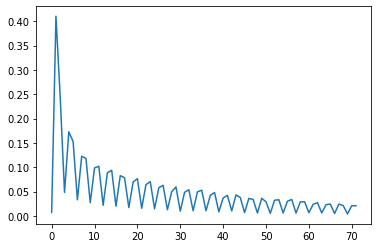

  0%|          | 0/225 [00:00<?, ?it/s]

[25,     1] loss: 0.005
[25,   101] loss: 0.022
[25,   201] loss: 0.018


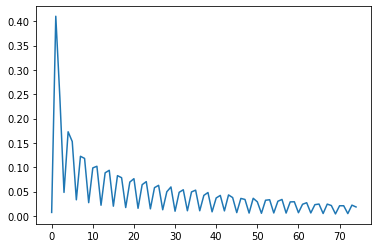

  0%|          | 0/225 [00:00<?, ?it/s]

[26,     1] loss: 0.005
[26,   101] loss: 0.017
[26,   201] loss: 0.026


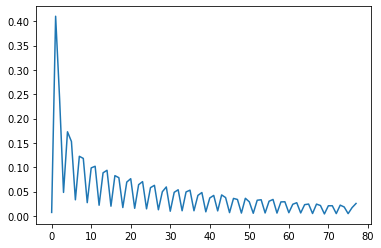

  0%|          | 0/225 [00:00<?, ?it/s]

[27,     1] loss: 0.005
[27,   101] loss: 0.022
[27,   201] loss: 0.017


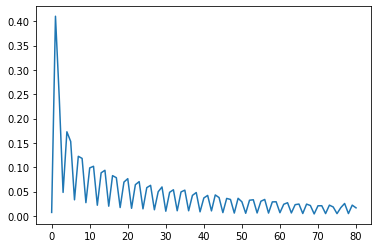

  0%|          | 0/225 [00:00<?, ?it/s]

[28,     1] loss: 0.004
[28,   101] loss: 0.019
[28,   201] loss: 0.014


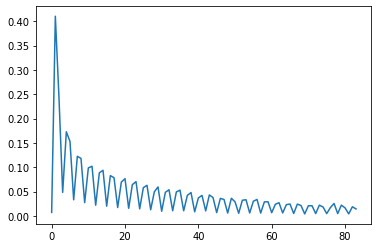

  0%|          | 0/225 [00:00<?, ?it/s]

[29,     1] loss: 0.005
[29,   101] loss: 0.014
[29,   201] loss: 0.017


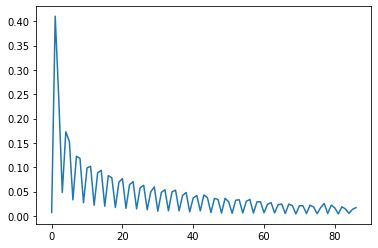

  0%|          | 0/225 [00:00<?, ?it/s]

[30,     1] loss: 0.004
[30,   101] loss: 0.013
[30,   201] loss: 0.017


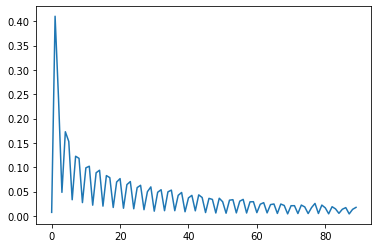

  0%|          | 0/225 [00:00<?, ?it/s]

[31,     1] loss: 0.004
[31,   101] loss: 0.013
[31,   201] loss: 0.014


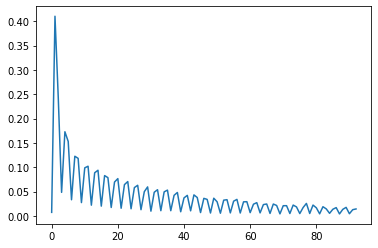

  0%|          | 0/225 [00:00<?, ?it/s]

[32,     1] loss: 0.004
[32,   101] loss: 0.014
[32,   201] loss: 0.015


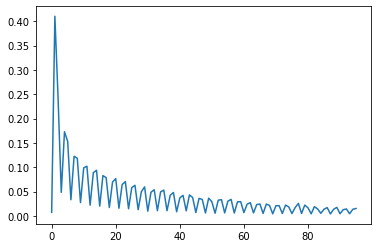

  0%|          | 0/225 [00:00<?, ?it/s]

[33,     1] loss: 0.004
[33,   101] loss: 0.017
[33,   201] loss: 0.013


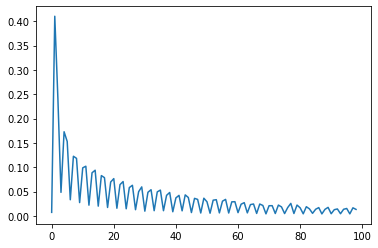

  0%|          | 0/225 [00:00<?, ?it/s]

[34,     1] loss: 0.002
[34,   101] loss: 0.008
[34,   201] loss: 0.010


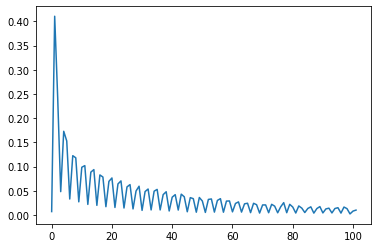

  0%|          | 0/225 [00:00<?, ?it/s]

[35,     1] loss: 0.003
[35,   101] loss: 0.012
[35,   201] loss: 0.009


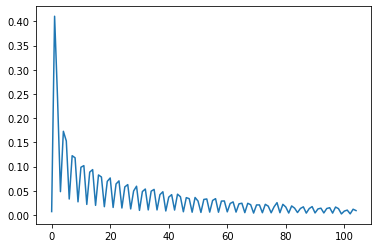

  0%|          | 0/225 [00:00<?, ?it/s]

[36,     1] loss: 0.003
[36,   101] loss: 0.008
[36,   201] loss: 0.011


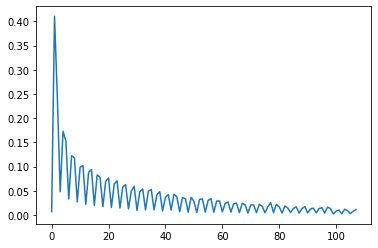

  0%|          | 0/225 [00:00<?, ?it/s]

[37,     1] loss: 0.004
[37,   101] loss: 0.009
[37,   201] loss: 0.009


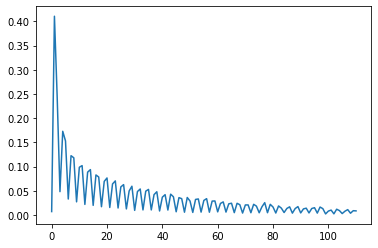

  0%|          | 0/225 [00:00<?, ?it/s]

[38,     1] loss: 0.003
[38,   101] loss: 0.010
[38,   201] loss: 0.006


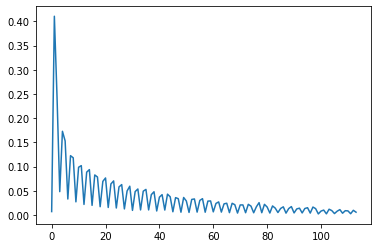

  0%|          | 0/225 [00:00<?, ?it/s]

[39,     1] loss: 0.004
[39,   101] loss: 0.009
[39,   201] loss: 0.012


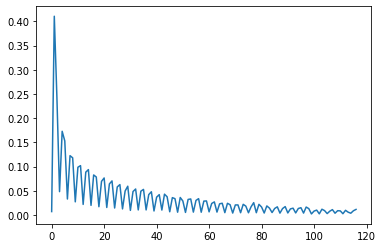

  0%|          | 0/225 [00:00<?, ?it/s]

[40,     1] loss: 0.002
[40,   101] loss: 0.008
[40,   201] loss: 0.009


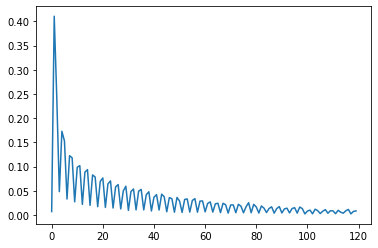

In [34]:
loss_fn = torch.nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

losses = []
running_loss = 0.0

for epoch in tqdm(range(40)):

    for i, batch in enumerate(tqdm(train_dataloader)):
        X_batch, y_batch = batch
        y_batch = y_batch.float()

        optimizer.zero_grad()
        y_pred = net(X_batch)

        loss = loss_fn(y_pred.reshape(-1), y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))

            losses.append(running_loss / 100)
            running_loss = 0.0
            
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

In [35]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

target, predicted = [], []

with torch.no_grad():
    for batch in test_dataloader:
        X_batch, y_batch = batch
        y_batch = y_batch.float()

        y_pred = net(X_batch).reshape(-1)

        for pred, label in zip(y_pred, y_batch):
            target.append(label)
            predicted.append(pred)

            if label == 0.:
                class_total[0] += 1
                if pred < 0.5:
                    class_correct[0] += 1
            elif label >= 0.5:
                class_total[1] += 1
                if label == pred.round():
                    class_correct[1] += 1

for i in range(2):
    print(f'Accuracy of class {"human (" + str(i) + ")"  if i == 1 else "spoof (" + str(i) + ")"}: {class_correct[i] / class_total[i]}\n'
          f'Class {"human (" + str(i) + ")"  if i == 1 else "spoof (" + str(i) + ")"} count: {class_total[i]}\n'
          f'Class {"human (" + str(i) + ")"  if i == 1 else "spoof (" + str(i) + ")"} correct: {class_correct[i]}\n')

fpr, tpr, thresholds = roc_curve(target, predicted, pos_label=1)

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print(f'EER: {eer}')

Accuracy of class spoof (0): 0.9848254931714719
Class spoof (0) count: 3954.0
Class spoof (0) correct: 3894.0

Accuracy of class human (1): 0.9311663479923518
Class human (1) count: 1046.0
Class human (1) correct: 974.0

EER: 0.03717754172932907


In [19]:
test_spectrogram_dataset[0]

[tensor([[ 10.5571,  -1.8270,  -5.3517,  ...,  -0.3448,   0.2481,  -5.4350],
         [ 12.1915,  -8.8194,  -5.7032,  ...,  -6.3867, -11.2991, -13.8511],
         [ 17.5804,   2.9197,  10.1863,  ...,  -6.0385, -18.3613, -13.4587],
         ...,
         [-34.0517, -34.4359, -18.4007,  ..., -26.7996, -32.8229, -50.6178],
         [-25.6873, -32.2921, -16.8047,  ..., -24.8843, -34.2578, -49.0275],
         [-28.3016, -31.7695, -22.6014,  ..., -21.8172, -27.9069, -53.6522]]),
 'sample_2038.wav']

In [26]:
# dataloader for test dataset
dataloader_test = DataLoader(test_spectrogram_dataset, batch_size=1, shuffle=False)

In [36]:
import csv

# write answers to csv
answers = []
with open('test_scores.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filename', 'score'])

    with torch.no_grad():
        for data in tqdm(dataloader_test):
            spectr, filename = data
            pred = net(spectr)
            # writer.writerow([str(filename[0]), pred.squeeze().numpy()])
            answers.append((str(filename[0]), pred.squeeze().numpy().round(3)))

    answers.sort(key=lambda x:x[0],reverse=False)
    writer.writerows((answers))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [37]:
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio

# record audiofile
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [44]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)

!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic

spec = SpectrogramDataset.get_spectrogram('file.wav')
spec = torch.unsqueeze(spec, 0)

with torch.no_grad():
    pred = net(spec)
    print(f'You are human with probability {pred.numpy()}')

You are human with probability [[0.13639389]]
